# Decision Tree Lab

### Analyzing IMBD Movie Ratings

Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.


- Make sure all your variables are the correct type (factor, character,numeric, etc.)
- 19 What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?
- Use three highest probabilities for falling into the threshold

In [137]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

1. Load the Data

In [138]:
# Load the data
movie_data_raw = pd.read_csv("../data/movie_metadata.csv")

2. Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

#### Target Variable 
Target Variable = IMDB Ratings greater than 8.0.

This step is combined with Step 3 in a data preprocessing function.

3. Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [139]:
# Drop NA Rows
#movie_data.isna().sum()
#movie_data = movie_data.dropna()

In [ ]:
# Data Preparation Function

def prepare_movie_data(movie_df):
    # Drop NA Rows
    movie_df = movie_df.dropna()

    # Collapse movie directors variable
    top10_director = movie_df.groupby(by='director_name').size().sort_values(ascending=False).head(10)
    movie_df["director_name"] = movie_df.director_name.apply(lambda x: 1 if x in top10_director else 0).astype("category")
    movie_df = movie_df.rename(columns={'director_name': 'top_director'})

    # Collapse actor_1 variable
    top30_actor = movie_df.groupby(by='actor_1_name').size().sort_values(ascending=False).head(30)
    movie_df["actor_1_name"] = movie_df.actor_1_name.apply(lambda x: 1 if x in top30_actor else 0).astype("category")
    movie_df = movie_df.rename(columns={'actor_1_name': 'top_lead_actor'})

    # Adjust the variable for genres
    genre = ["Drama", "Comedy", "Action", "Horror", "Fantasy", "Documentary", "Crime", "Adventure", "Animation", "Biography"]
    movie_df['genres'] = movie_df['genres'].str.split("|")
    movie_df['genres'] = movie_df.genres.apply(lambda x: x[0] if x[0] in genre else "Other").astype("category")

    # Collapse genre variable
    #movie_df['genres'] = movie_df['genres'].str.split("|").apply(lambda x: x[0])
    #top3_genre = movie_df.groupby(by='genres').size().sort_values(ascending=False).head(3)
    #movie_df["genres"] = movie_df.genres.apply(lambda x: "Top 3" if x in top3_genre else "Other").astype("category")

    # Collapse language variable
    movie_df['language'] = movie_df.language.apply(lambda x: 1 if x=="English" else 0).astype("category")
    movie_df = movie_df.rename(columns={'language': 'language_english'})

    # Collapse country variable
    movie_df['country'] = movie_df.country.apply(lambda x: 1 if x=="USA" else 0).astype("category")
    movie_df = movie_df.rename(columns={'country': 'country_usa'})

    # Collapse rating variable
    ratings = ["PG", "PG-13", "R"]
    movie_df['content_rating'] = movie_df.content_rating.apply(lambda x: x if x in ratings else "Other").astype("category")

    # Drop unnecessary features
    drop_cols = ['color', 'title_year', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'facenumber_in_poster', 'cast_total_facebook_likes', 'movie_title', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'gross']
    movie_df = movie_df.drop(columns=drop_cols)

    # Label Encoding
    le_columns = ['content_rating', 'genres']
    label_encoder = LabelEncoder()
    movie_df[le_columns[0]] = label_encoder.fit_transform(movie_df[le_columns[0]])
    movie_df[le_columns[1]] = label_encoder.fit_transform(movie_df[le_columns[1]])

    # Encode categorical variables into numeric
    #category_cols = list(movie_df.select_dtypes('category'))
    #movie_df = pd.get_dummies(movie_df, columns=category_cols, drop_first=True)

    # Classify target variable
    imdb_score_target = 8.0
    movie_df['imdb_score'] = movie_df.imdb_score.apply(lambda x: 1 if x >= imdb_score_target else 0).astype('category')

    return movie_df


movie_data = prepare_movie_data(movie_data_raw)


/tmp/ipykernel_902/1050130078.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df["director_name"] = movie_df.director_name.apply(lambda x: 1 if x in top10_director else 0).astype("category")


4. Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

5. Determine the baserate or prevalence for the classifier, what does this number mean?

The baserate/prevalence of the classifier is the the rate of target variables that are the positive class. In this case, it is the proportion of movies that have an imdb score greater than or equal to 8.0.

In [141]:
# Calculate prevalence of classifier

prevalence = movie_data.imdb_score.value_counts()[1]/len(movie_data)
print(prevalence)

0.05619174434087883


6. Split your data into test, tune, and train. (80/10/10)

In [142]:
# Separate features and target variable
x = movie_data.drop(columns='imdb_score')
y = movie_data['imdb_score']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=45)

# Split into test and tune sets
x_tune, x_test, y_tune, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=45)


7. Create the kfold object for cross validation.

In [143]:
# Instantiate KFold Object

kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=45)

8. Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search)

In [144]:
# Define scoring metrics to evaluate the model
#scoring_metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

# Edit precision scorer to eliminate warning errors
precision = make_scorer(precision_score, zero_division=0)

scoring_metrics = {'accuracy': 'accuracy', 
                   'recall': 'recall', 
                   'precision': precision, 
                   'f1': 'f1', 
                   'roc_auc': 'roc_auc'}

# Create the max depth hyperparameter
max_depth_param = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

9. Build the classifier object

In [145]:
# Instantiate Decision Tree Classifier object

dt = DecisionTreeClassifier(random_state=45)

10. Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [146]:
# Implement Grid Search on the Decision Tree Classifier
search = GridSearchCV(dt, max_depth_param, scoring=scoring_metrics, n_jobs=1, refit='f1', cv=kf)

11. Fit the model to the training data.

In [147]:
# Execute the search on the training data
dt_model = search.fit(x_train, y_train)

#dt_model.cv_results_

12. What is the best depth value?

In [148]:
# Evaluate the best depth value
best_depth = dt_model.best_estimator_

print(best_depth)

DecisionTreeClassifier(max_depth=10, random_state=45)


13. Print out the model

In [149]:
# Print model
print(dt_model)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=4, n_splits=5, random_state=45),
             estimator=DecisionTreeClassifier(random_state=45), n_jobs=1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': 'recall', 'roc_auc': 'roc_auc'})


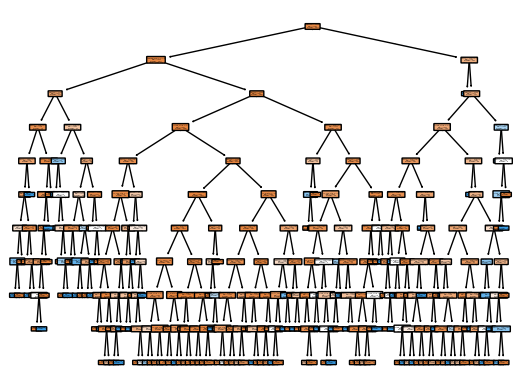

In [150]:
# Visualize Best Model
plt.figure()
plot_tree(best_depth, feature_names=x_train.columns, filled=True, rounded=True)
plt.show()

In [151]:
# Create a table of performance metric scores

# Extract scores
accuracy_result = dt_model.cv_results_['mean_test_accuracy']
recall_result = dt_model.cv_results_['mean_test_recall']
precision_result = dt_model.cv_results_['mean_test_precision']
f1_result = dt_model.cv_results_['mean_test_f1']
roc_auc_result = dt_model.cv_results_['mean_test_roc_auc']

# Make table
dt_model_scores = pd.DataFrame({"Depth": max_depth_param['max_depth'],
                                "Accuracy": accuracy_result,
                                "Recall": recall_result,
                                "Precision": precision_result,
                                "F1 Score": f1_result,
                                "AUC Score": roc_auc_result})

dt_model_scores

,Depth,Accuracy,Recall,Precision,F1 Score,AUC Score
0,1,0.943742,0.000000,0.000000,0.000000,0.621251
1,2,0.942327,0.014706,0.138526,0.025214,0.673548
2,3,0.942660,0.035651,0.334484,0.061790,0.723050
3,4,0.942161,0.065107,0.455817,0.108745,0.718753
4,5,0.939331,0.078342,0.360606,0.122628,0.690094
5,6,0.934420,0.079857,0.236519,0.116162,0.665529
6,7,0.931092,0.103565,0.237604,0.141613,0.625393
7,8,0.926348,0.133200,0.232746,0.167805,0.581333
8,9,0.923270,0.139260,0.211659,0.165684,0.556962
9,10,0.919608,0.177763,0.225860,0.197453,0.548658


14. View the results, comment on how the model performed using the metrics you selected.

Looking at the performance metric scores data frame, the model scored differently for different metrics across the different levels of `max_depth`. For instance, the AUC was the highest with a max depth of 3, as well as accuracy. However, precision was the greatest with a depth of 4 and recall was the greatest with a depth of 12. This just goes to show that even though the model may score well at one depth level for one of the metrics, it may be better off at a different depth for another metric.

15. Which variables appear to be contributing the most (variable importance) 

In [152]:
# Determine the most important variables for the best model
var_importance = pd.DataFrame(best_depth.feature_importances_, index=x_train.columns, columns=['Importance']).sort_values(by="Importance", ascending=False)

var_importance

,Importance
budget,0.399544
duration,0.334150
genres,0.120112
content_rating,0.069609
language_english,0.026846
top_director,0.025051
top_lead_actor,0.019121
country_usa,0.005567


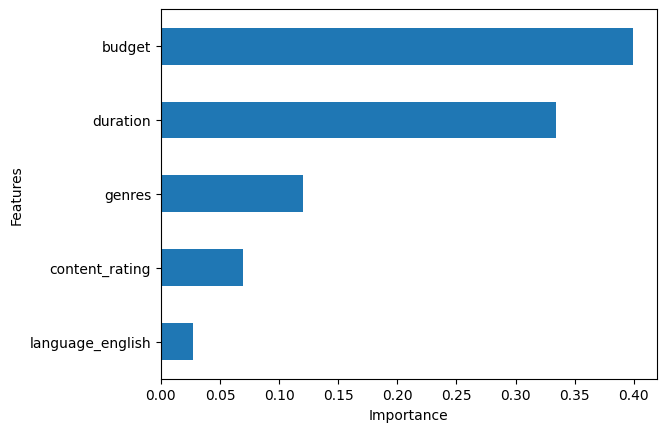

In [153]:
# Graph the Variable Importance
plt.figure()
var_importance.Importance.nlargest().sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

The features `budget`, `duration`, and `genres` contribute the most to the model in that order.

16. Use the predict method on the tune data and print out the results.

In [154]:
# Predict on the tune set
tune_pred = dt_model.predict(x_tune)

# Calculate performance metrics of the tune set
#accuracy = best_depth.score(x_tune, y_tune)
tune_accuracy = accuracy_score(y_tune, tune_pred)
tune_precision = precision_score(y_tune, tune_pred)
tune_recall = recall_score(y_tune, tune_pred)
tune_auc = roc_auc_score(y_tune, tune_pred)

# Print performance metrics of the tune set
print("Accuracy of the Tune Set:", tune_accuracy)
print("Recall of the Tune Set:", tune_recall)
print("Precision of the Tune Set:", tune_precision)
print("AUC Score of the Tune Set:", tune_auc)

# Print out the predicted results
pred_df = pd.DataFrame({"Predicted": tune_pred,
                        "Actual": y_tune})

pred_df.head(10)


Accuracy of the Tune Set: 0.928
Recall of the Tune Set: 0.3333333333333333
Precision of the Tune Set: 0.35
AUC Score of the Tune Set: 0.6483050847457626


,Predicted,Actual
939,0,0
688,0,0
4680,0,0
3471,0,0
557,0,0
3128,0,0
4063,0,0
1439,0,0
2162,0,0
3280,1,1


17. How does the model perform on the tune data?

The tune set had an accuracy score in the same range as the testing data, meaning it performed as expected with the model. The AUC score of the tune data is slightly higher the test data AUC.

However, the tune data scored surprisingly high for both recall and precision in relation to the test data. Based on the Confusion Matrix below, we can see that the positive class is very small, so there are lots of false positives and false negatives being predicted - even more so than true positives.

Overall, the model performed well on the tune data.

18. Print out the confusion matrix for the tune data, what does it tell you about the model?

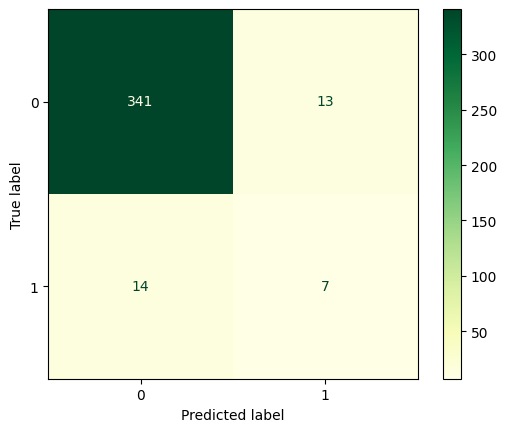

In [155]:
# Create a Confusion Matrix from the tuning data predictions
cm = confusion_matrix(y_tune, tune_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
cm_display.plot(cmap='YlGn')
plt.show()

The confusion matrix reveals how small in amount the positive class is (movies with an IMDB rating above 8.0). Resultingly, many false positives and false negatives are being predicted, leading to quite low precision and recall scores. However, the accuracy remains relatively high thanks to the abundance of the negative class (movies with an IMDB rating below 8.0) and the accuracy of the model in being able to predict these movies.

19. What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?

In [156]:
# Identify the top 3 movies based on the tune set

# Create a new dataframe from the x and y tune sets
tune_df = pd.concat([x_tune, y_tune], axis=1)

# Add the predicted values to the set
tune_df['predicted'] = tune_pred

# Sort the tune df and pick out the top 3 movies
top3_tune = tune_df.sort_values(by="predicted", ascending=False).head(3)

# Create a variable to store the index of the top 3 movies
top3_tune_index = list(top3_tune.index)

# Locate the movie titles at these 3 indexes in the original movie df
top3_tune_movies = movie_data_raw.iloc[top3_tune_index]

# Print out the movie titles of the top 3 movies in the tune set
print(top3_tune_movies['movie_title'])


2829               Downfall 
499             The Postman 
4259    The Lives of Others 
Name: movie_title, dtype: object


In [157]:
# Determine variable importance for the top 3 movies of the tune set

# Create new x and y sets based on the top 3 tune movies
#x_tune_top = top3_tune.drop(columns=['predicted', 'imdb_score'])
#y_tune_top = top3_tune['imdb_score']

# Refit the model on the tune data
dt_tune_model = search.fit(x_tune, y_tune)

# Pick out the best tune model (based on the max depth parameter)
best_tune_model = dt_tune_model.best_estimator_

# Determine the feature importance for this best model
tune_var_importance = pd.DataFrame({"Importance": best_tune_model.feature_importances_}, index=x_tune.columns).sort_values(by="Importance", ascending=False)

tune_var_importance.head(3)

,Importance
duration,0.68305
budget,0.31695
top_director,0.00000


The top 3 movies based on the predicted values from the tune set are 
1. Downfall
2. The Postman
3. The Lives of Others

The two most important variables in predicting these top 3 movies were duration and budget.

20. Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

Accuracy of the Tune Set: 0.9466666666666667
Recall of the Tune Set: 0.2857142857142857
Precision of the Tune Set: 0.5454545454545454
AUC Score of the Tune Set: 0.6357949959644874


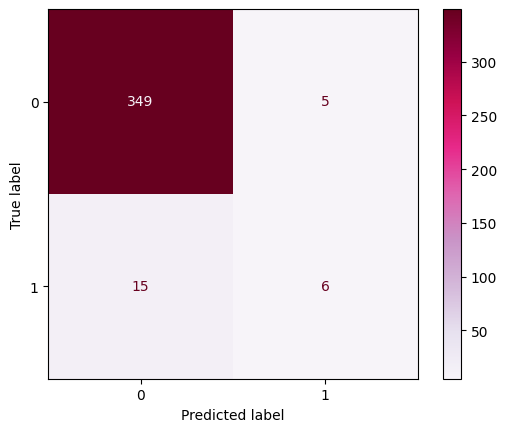

In [158]:
# Define a new parameter to run the decision tree model grid search on
# Parameter: min_samples_split
min_samples_split_param = {"min_samples_split": [2, 5, 10, 15, 20]}

# Instantiate another grid search with this new parameter
search2 = GridSearchCV(dt, min_samples_split_param, scoring=scoring_metrics, n_jobs=1, refit='f1', cv=kf)

# Execute the grid search on the train data
dt_model2 = search2.fit(x_train, y_train)

# Determine the best model based on the min_sample_split parameter
best_model2 = dt_model2.best_estimator_
#best_model2

# Predict on the tune data using the best model
pred2 = dt_model2.predict(x_tune)

# Calculate the performance metrics based on the predicted values
tune_accuracy2 = accuracy_score(y_tune, pred2)
tune_precision2 = precision_score(y_tune, pred2)
tune_recall2 = recall_score(y_tune, pred2)
tune_auc2 = roc_auc_score(y_tune, pred2)

# Print performance metrics of the tune set
print("Accuracy of the Tune Set:", tune_accuracy2)
print("Recall of the Tune Set:", tune_recall2)
print("Precision of the Tune Set:", tune_precision2)
print("AUC Score of the Tune Set:", tune_auc2)

# Create a Confusion Matrix from the tune predictions and the new model
cm = confusion_matrix(y_tune, pred2)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model2.classes_)
cm_display.plot(cmap='PuRd')
plt.show()


21. Did the model improve with the new hyperparameter search?

In [159]:
# Create a df to compare the first and second model
model1 = [tune_accuracy, tune_precision, tune_recall, f1_score(y_tune, tune_pred), tune_auc]
model2 = [tune_accuracy2, tune_precision2, tune_recall2, f1_score(y_tune, pred2), tune_auc2]

model_comparison_df = pd.DataFrame({"Model 1": model1, "Model 2": model2}, index=["Accuracy", "Precision", "Recall", "F1 Score", "AUC Score"])

model_comparison_df

,Model 1,Model 2
Accuracy,0.928000,0.946667
Precision,0.350000,0.545455
Recall,0.333333,0.285714
F1 Score,0.341463,0.375000
AUC Score,0.648305,0.635795


The model did not improve significantly with the new hyperparameter `min_samples_split`, as they both performed differently depending on various performance metrics. The first model, which found the best `max_depth`, has a greater recall and AUC Score than the second model. The second model, which found the best `min_samples_split` has a better accuracy, precision, and f1 score. Overall, it appears that the model improved slightly with this different hyperparameter.

22. Using the better model, predict the test data and print out the results.

Test Data Performance
Accuracy: 0.925531914893617
Recall: 0.23076923076923078
Precision: 0.14285714285714285
F1 Score: 0.17647058823529413
AUC Score: 0.5573440643863179


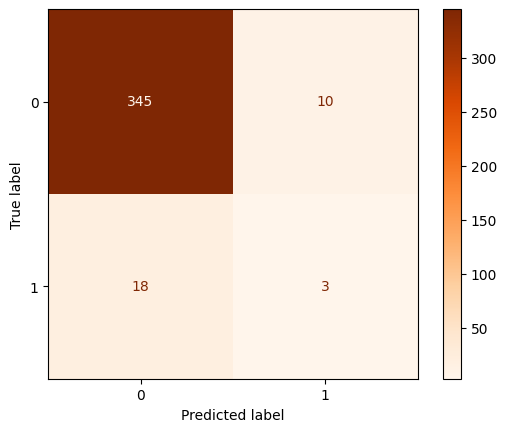

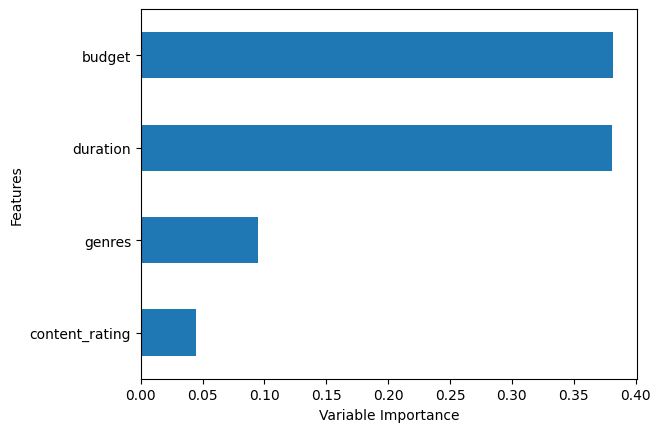

In [167]:
# Better model = dt_model2

# Predict on the test data
pred_test = dt_model2.predict(x_test)

# Calculate the performance metrics based on the predicted values
test_accuracy = accuracy_score(y_test, pred_test)
test_precision = precision_score(y_test, pred_test)
test_recall = recall_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test)
test_auc = roc_auc_score(y_test, pred_test)

# Print performance metrics of the test data
print("Test Data Performance")
print("Accuracy:", test_accuracy)
print("Recall:", test_precision)
print("Precision:", test_recall)
print("F1 Score:", test_f1)
print("AUC Score:", test_auc)

# Create a Confusion Matrix from the test predictions
cm = confusion_matrix(y_test, pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model2.classes_)
cm_display.plot(cmap='Oranges')
plt.show()

# Determine variable importance
var_importance2 = pd.DataFrame(best_model2.feature_importances_, index=x_test.columns, columns=['Importance']).sort_values(by="Importance", ascending=False)

# Graph variable importance
plt.figure()
var_importance2.Importance.nlargest(4).sort_values().plot(kind="barh")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()


23. Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.

#### Summary
Overall, I found that this dataset was not very useful for predicting aspects of movies that can be indicative of a high IMDB rating. The most useful feature correlating with a IMDB score of above 8.0 was budget, which is self-explanatory as a movie with a larger budget has more potential to do well.

As this process went on, I kept eliminating variables that I found to be not useful for what this model was trying to predict. For instance variables such as gross and number of likes are only valuable after a movie is released and have no impact on the process of trying to produce a highly rated movie. Other variables such as color and aspect ratio should be irrelevant because all movies nowadays are generally made in color and with a standard aspect ratio, and it would not be valuable advice to make a movie otherwise. The variables having to do with Facebook likes can be misleading, because Facebook was only created in 2004 and has drastically grown in users since then, while IMDB ratings have existed for far longer. This means that older movies that are highly rated will be misrepresented in comparison to newer movies that have been released in the same time span as Facebook. Other variables, such as title, year, and more are not relevant when recommending useful insights to produce a highly-rated movie. By the time these variables were dropped, the only useful variables remaining were budget, genre, duration, rating, and whether the movie has a well-established director or actor. 

Along the way, I also learned that models with different hyperparameter settings will vary in performance metrics scores. In other words, the best model may not always be the model with the best accuracy, precision, recall, and AUC score. Some of these scores may be better for different models. As a result, it is best to pick out a performance metric that best aligns with the goal of what you are trying to predict.


#### Recommendation
Given the problem of trying to predict new movies that might get high IMDB scores, I looked at common aspects that might lead existing movies to be rated by IMDB as 8.0 or higher. I found that movies with larger budgets tended to be rated higher. Also movies with a duration of roughly **170 minutes** OR roughly **125 minutes** are likely to be rated highly. Though movies across all genres have the potential to be rated highly, **action** movies have historically done the best. Similarly, **R rated** movies are best correlated with higher scores, though this aspect is generally unimportant and movies with other content ratings still have the potential to score highly.

***In conclusion, I recommend scaling up the budget to create an exhilarating, dramatic action movie that is just shy of 3 hours long.***